   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2  1.2  3.9   

   FWI      Classes  Region  
0  0.5  not fire          0  
1  0.4  not fire          0  
2  0.1  not fire          0  
3  0.0  not fire          0  
4  0.5  not fire          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  


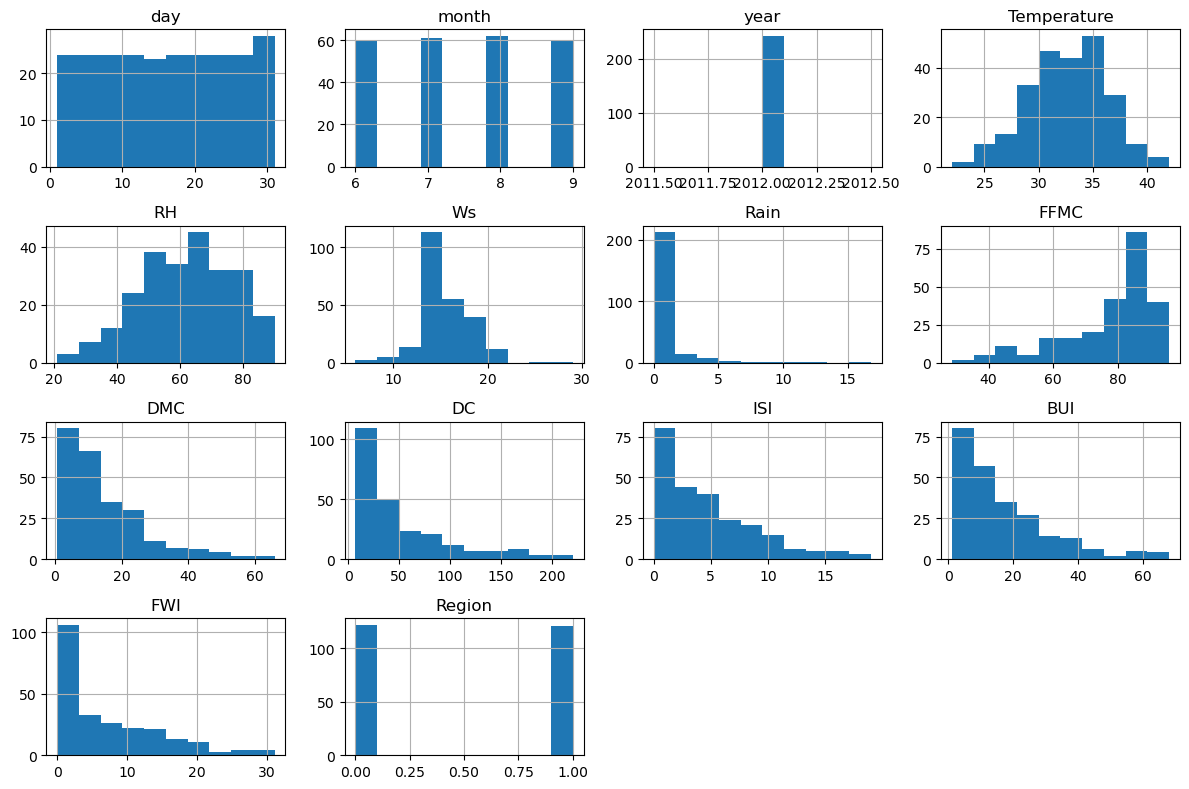

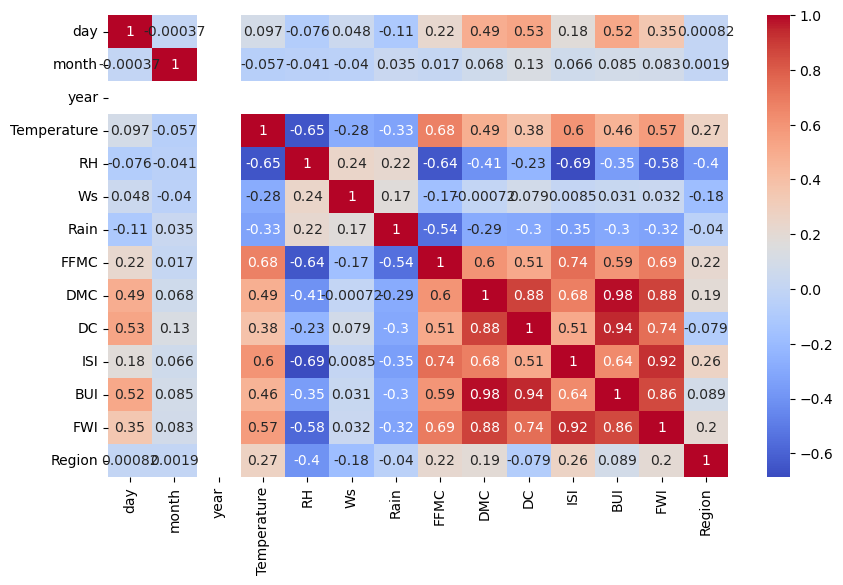

Best Alpha: 0.001


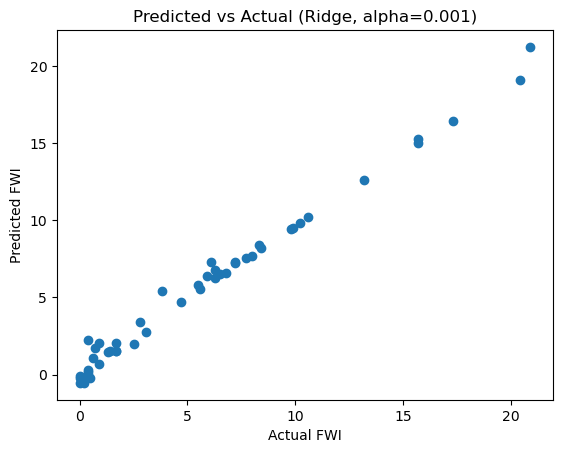

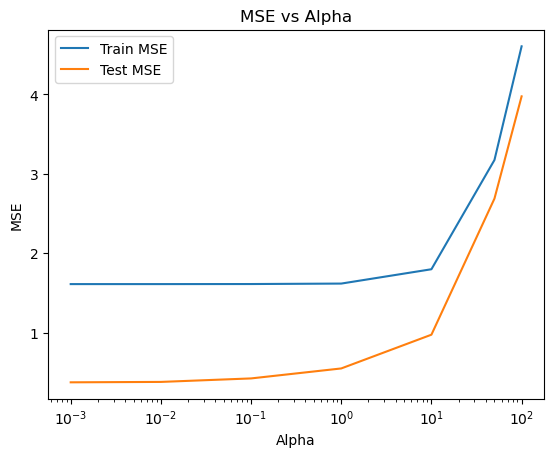

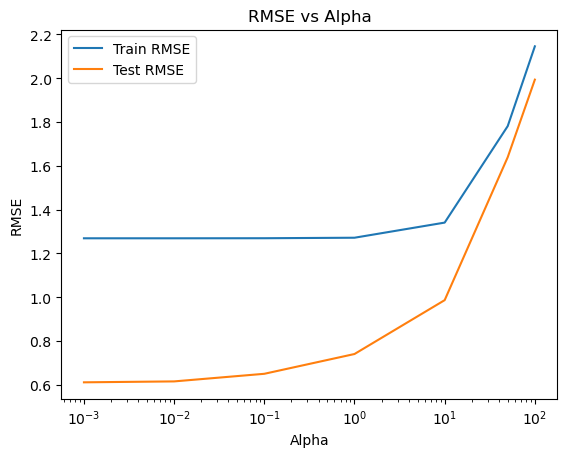

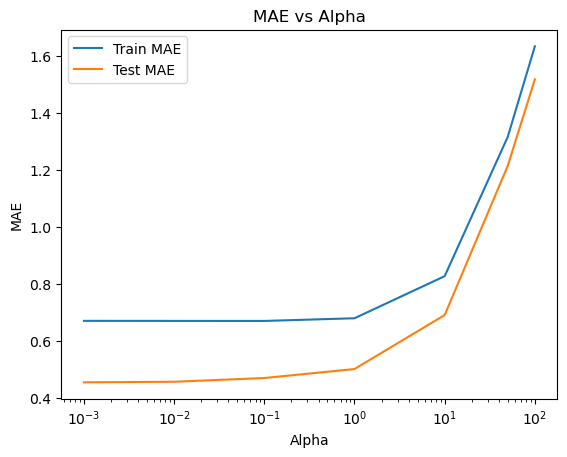

Train MSE: 1.6106879581942053
Test MSE: 0.37362672043278244
Model is UNDERFITTING


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

# --------------------------
# LOAD DATA
# --------------------------
df = pd.read_csv(r"D:\Infosys Springboard Internship\FWI Dataset.csv")

# --------------------------
# BASIC INFO
# --------------------------
print(df.head())
print(df.info())
print(df.describe())

# --------------------------
# CLEANING
# --------------------------
df = df.fillna(df.mean(numeric_only=True))
df = df.drop_duplicates()

# --------------------------
# HISTOGRAM VISUALIZATION
# --------------------------
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# --------------------------
# CORRELATION HEATMAP
# --------------------------
corr = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# --------------------------
# FEATURE SELECTION
# --------------------------
features = ['day','month','year','Temperature','RH','Ws','Rain',
            'FFMC','DMC','DC','ISI','BUI','Region']

# Encode Region (categorical)
df['Region'] = df['Region'].astype('category').cat.codes

X = df[features].values
y = df['FWI'].values

# --------------------------
# SPLIT
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# SCALING (IMPORTANT)
# --------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# --------------------------
# RIDGE REGRESSION
# --------------------------
alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100]

mse_train, mse_test = [], []
rmse_train, rmse_test = [], []
mae_train, mae_test = [], []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred  = model.predict(X_test_scaled)

    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    
    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))

# BEST ALPHA
best_alpha = alphas[mse_test.index(min(mse_test))]
print("Best Alpha:", best_alpha)

best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

# Save model
with open("ridge.pkl", "wb") as f:
    pickle.dump(best_model, f)

# --------------------------
# PLOTS
# --------------------------

# Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual FWI")
plt.ylabel("Predicted FWI")
plt.title(f"Predicted vs Actual (Ridge, alpha={best_alpha})")
plt.show()

# MSE vs Alpha
plt.plot(alphas, mse_train, label="Train MSE")
plt.plot(alphas, mse_test, label="Test MSE")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.title("MSE vs Alpha")
plt.legend()
plt.show()

# RMSE vs Alpha
plt.plot(alphas, rmse_train, label="Train RMSE")
plt.plot(alphas, rmse_test, label="Test RMSE")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("RMSE vs Alpha")
plt.legend()
plt.show()

# MAE vs Alpha
plt.plot(alphas, mae_train, label="Train MAE")
plt.plot(alphas, mae_test, label="Test MAE")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.title("MAE vs Alpha")
plt.legend()
plt.show()

# --------------------------
# OVERFITTING CHECK
# --------------------------
train_mse = mse_train[alphas.index(best_alpha)]
test_mse  = mse_test[alphas.index(best_alpha)]

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

if train_mse < test_mse * 0.7:
    print("Model is OVERFITTING")
elif train_mse > test_mse * 1.3:
    print("Model is UNDERFITTING")
else:
    print("Model is GOOD — No Overfitting/Underfitting")


In [3]:
# ----------------------------------------------
# 🔥 Single-File Attractive Flask Dashboard (NO NGROK)
# ----------------------------------------------

import os
import threading
import pickle
from pathlib import Path

from flask import Flask, request, render_template_string, jsonify
import numpy as np
import pandas as pd

# Try loading your real model
MODEL = Path("ridge.pkl")
SCALER = Path("scaler.pkl")

if MODEL.exists() and SCALER.exists():
    model = pickle.load(open(MODEL, "rb"))
    scaler = pickle.load(open(SCALER, "rb"))
    print("Loaded ridge.pkl and scaler.pkl successfully.")
else:
    print("ridge.pkl / scaler.pkl not found — creating demo model so dashboard works.")
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import StandardScaler

    X_demo = np.random.rand(200, 13)
    y_demo = X_demo[:, 0] * 12 + np.random.randn(200)

    scaler = StandardScaler().fit(X_demo)
    model = Ridge().fit(scaler.transform(X_demo), y_demo)

    pickle.dump(model, open("ridge.pkl", "wb"))
    pickle.dump(scaler, open("scaler.pkl", "wb"))
    print("Demo model saved as ridge.pkl & scaler.pkl.")

# Flask App
app = Flask(__name__)

# In-memory history for chart
HISTORY = []

# ----------------------------------------------
# HTML UI (Beautiful, Interactive Dashboard)
# ----------------------------------------------

HTML = """
<!DOCTYPE html>
<html>
<head>
  <title>🔥 FWI Prediction Dashboard</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
  <style>
    body {
      background: linear-gradient(135deg,#fff0e1,#ffd6e8,#e8f4ff);
      font-family: 'Segoe UI', sans-serif;
      padding: 25px;
    }
    .glass {
      background: rgba(255,255,255,0.85);
      border-radius: 15px;
      padding: 25px;
      box-shadow: 0 8px 25px rgba(0,0,0,0.1);
    }
    .heading {
      font-weight: 700;
      color: #ff4d4d;
    }
    .badge-result {
      font-size: 2.2rem;
      padding: 10px 25px;
    }
  </style>
</head>

<body>

<div class="container">

  <div class="glass mb-4">
    <h2 class="heading">🔥 Fire Weather Index Prediction Dashboard</h2>
    <p class="text-muted">Enter weather & fuel features to predict FWI.</p>
  </div>

  <div class="row g-4">

    <!-- Input Form -->
    <div class="col-lg-6">
      <div class="glass">

        <form id="fwiForm">

          <div class="row">
            <div class="col-4 mb-3">
              <label class="form-label">Day</label>
              <input type="number" name="day" class="form-control" value="1">
            </div>
            <div class="col-4 mb-3">
              <label class="form-label">Month</label>
              <input type="number" name="month" class="form-control" value="6">
            </div>
            <div class="col-4 mb-3">
              <label class="form-label">Year</label>
              <input type="number" name="year" class="form-control" value="2012">
            </div>

            <div class="col-6 mb-3">
              <label class="form-label">Temperature (°C)</label>
              <input type="range" class="form-range" min="-10" max="60" value="25"
                     name="Temperature" oninput="tempOut.value=this.value">
              <output id="tempOut" class="fw-bold text-danger">25</output>
            </div>

            <div class="col-6 mb-3">
              <label class="form-label">Humidity (%)</label>
              <input type="range" class="form-range" min="0" max="100" value="40"
                     name="RH" oninput="rhOut.value=this.value">
              <output id="rhOut" class="fw-bold text-danger">40</output>
            </div>

            <div class="col-6 mb-3">
              <label class="form-label">Wind Speed (km/h)</label>
              <input type="range" class="form-range" min="0" max="150" value="10"
                     name="Ws" oninput="wsOut.value=this.value">
              <output id="wsOut" class="fw-bold text-danger">10</output>
            </div>

            <div class="col-6 mb-3">
              <label class="form-label">Rain (mm)</label>
              <input type="number" name="Rain" class="form-control" value="0">
            </div>

            <div class="col-4 mb-3">
              <label class="form-label">FFMC</label>
              <input type="number" name="FFMC" class="form-control" value="85">
            </div>
            <div class="col-4 mb-3">
              <label class="form-label">DMC</label>
              <input type="number" name="DMC" class="form-control" value="10">
            </div>
            <div class="col-4 mb-3">
              <label class="form-label">DC</label>
              <input type="number" name="DC" class="form-control" value="200">
            </div>

            <div class="col-4 mb-3">
              <label class="form-label">ISI</label>
              <input type="number" name="ISI" class="form-control" value="8">
            </div>
            <div class="col-4 mb-3">
              <label class="form-label">BUI</label>
              <input type="number" name="BUI" class="form-control" value="50">
            </div>

            <div class="col-4 mb-3">
              <label class="form-label">Region</label>
              <select class="form-select" name="Region">
                <option value="0">Region 0</option>
                <option value="1">Region 1</option>
                <option value="2">Region 2</option>
              </select>
            </div>

          </div>

          <button class="btn btn-danger w-100 mt-3" type="submit">Predict FWI</button>

        </form>

      </div>
    </div>


    <!-- Prediction Output -->
    <div class="col-lg-6">
      <div class="glass">
        <h5>Prediction</h5>
        <span id="resultBadge" class="badge bg-danger text-white badge-result">--</span>
        <p id="resultText" class="text-muted mt-2">Prediction will appear here.</p>
      </div>

      <div class="glass mt-4">
        <h5>Prediction History</h5>
        <canvas id="historyChart" style="height:300px;"></canvas>
      </div>
    </div>

  </div>

</div>


<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>

<script>
let ctx = document.getElementById("historyChart").getContext("2d");
let chart = new Chart(ctx, {
  type: 'line',
  data: { labels: [], datasets: [{ label: "FWI", data: [], tension: 0.3 }] },
  options: { responsive: true }
});

document.getElementById("fwiForm").addEventListener("submit", async function(e){
  e.preventDefault();

  let fd = new FormData(this);
  let payload = {};
  fd.forEach((v,k)=> payload[k]=v);

  let res = await fetch("/predict", {
    method:"POST",
    headers:{ "Content-Type":"application/json" },
    body: JSON.stringify(payload)
  });

  let out = await res.json();

  document.getElementById("resultBadge").innerHTML = out.pred.toFixed(2);
  document.getElementById("resultText").innerHTML = "FWI = " + out.pred.toFixed(2);

  chart.data.labels.push(new Date().toLocaleTimeString());
  chart.data.datasets[0].data.push(out.pred);
  chart.update();
});
</script>

</body>
</html>
"""

# ----------------------------------------------
# Flask Routes
# ----------------------------------------------

@app.route("/")
def home():
    return render_template_string(HTML)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()

    order = ['day','month','year','Temperature','RH','Ws','Rain',
             'FFMC','DMC','DC','ISI','BUI','Region']

    x = [float(data[v]) for v in order]
    x_scaled = scaler.transform([x])
    pred = float(model.predict(x_scaled)[0])

    HISTORY.append(pred)

    return jsonify({"pred": pred})


# ----------------------------------------------
# Start Flask (no ngrok)
# ----------------------------------------------

def run():
    app.run(host="127.0.0.1", port=5000, debug=False)

thread = threading.Thread(target=run)
thread.start()

print("\n🚀 Flask app started!")
print("👉 Open in browser:  http://127.0.0.1:5000/")


Loaded ridge.pkl and scaler.pkl successfully.

🚀 Flask app started!
👉 Open in browser:  http://127.0.0.1:5000/
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Dec/2025 23:06:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Dec/2025 23:06:37] "POST /predict HTTP/1.1" 200 -
